In [2]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
from correctData import *
import copy

warnings.filterwarnings("ignore")

# Load and Process Data

In [7]:
inmet_csv = './historical_data_BOMJESUSDALAPA.csv'
save_scaler = "florianopolis_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 15*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      df_inmet.iloc[posicao_final-1,:].data,df_inmet.iloc[posicao_final-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
2020/07/17 0 2020/07/31 23


# SARIMAX 

## Auto ARIMA

In [5]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-92.428, Time=0.50 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-807.455, Time=3.87 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-545.838, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-60.479, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-650.212, Time=0.43 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-737.426, Time=3.36 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=15.27 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-806.461, Time=4.53 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=-805.127, Time=4.65 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=-714.022, Time=3.74 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=-

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 24),
      suppress_warnings=True, with_intercept=False)

In [6]:
mod = SARIMAX(endog=gen, exog=exog, order=(3, 0, 2), seasonal_order=(2, 0, 2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -825.1507882853775, Mape: 0.9518494576816882


## PSO-ACO Parametrization

In [7]:
p = [0, 1, 2, 3, 4]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2, 3]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
exogColumns = ['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt', 'vento_velocidade_mps', 'vento_rajada_max_mps']
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, exogColumns=exogColumns, verbose=False)
                                   
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-02-09 23:08:28,838 - root - INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,838: INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,841 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,841: INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,843 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,843: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,845 - root - INFO - 5
2021-02-09 23:08:28,845: INFO - 5
2021-02-09 23:08:29,424 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 

In [10]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,2,3]], order=(1,0,0), seasonal_order=(2,0,2,24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -831.8021789080478, Mape: 0.9233119200458031


## DUMP Sarimax

In [11]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

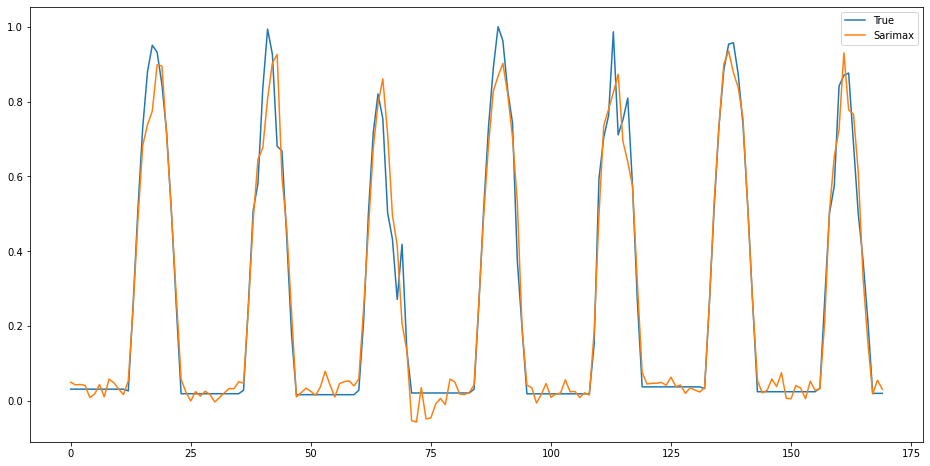

In [3]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

## Train

In [4]:
tr_ts_percents=[80,20]

In [22]:
# ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15, prob_mut=0.8,
#                                  tr_ts_percents=tr_ts_percents).search_best_model()
# best_mlp_residual = ag_mlp_residual._best_of_all
# pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

| 3/4 [00:22<00:07,  7.59s/it]
100%|██████████| 4/4 [00:27<00:00,  6.96s/it]

100%|██████████| 4/4 [00:19<00:00,  4.99s/it]

100%|██████████| 4/4 [01:19<00:00, 19.81s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

100%|██████████| 4/4 [00:47<00:00, 12.00s/it]

100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

100%|██████████| 4/4 [00:53<00:00, 13.38s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

100%|██████████| 4/4 [00:22<00:00,  5.69s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

 25%|██▌       | 1/4 [17:22<52:06, 1042.02s/it]generation: 1

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

100%|██████████| 4/4 [00:47<00:00, 11.98s/it]

100%|██████████| 4/4 [00:13<00:00,  3.47s/it]

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

100%|█████████

## Análise Resultados

[7, 15, 12, 8, MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(66, 3, 1), learning_rate='invscaling',
             max_iter=500, solver='lbfgs'), MLPRegressor(early_stopping=True, hidden_layer_sizes=(22, 44, 9), max_iter=500,
             solver='lbfgs'), 0.031054650812002642]
Teste para saber se pegou o melhor mesmo! 0.031054650812002642 == 0.031054650812002642 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.031054650812002642
MSE:  0.003046259939783712
MAPE:  0.19175864064979317
GANHO MAE:
0.003121194195040533
GANHO MSE:
-0.2050411309633411
GANHO MAPE:
0.4498936413009397


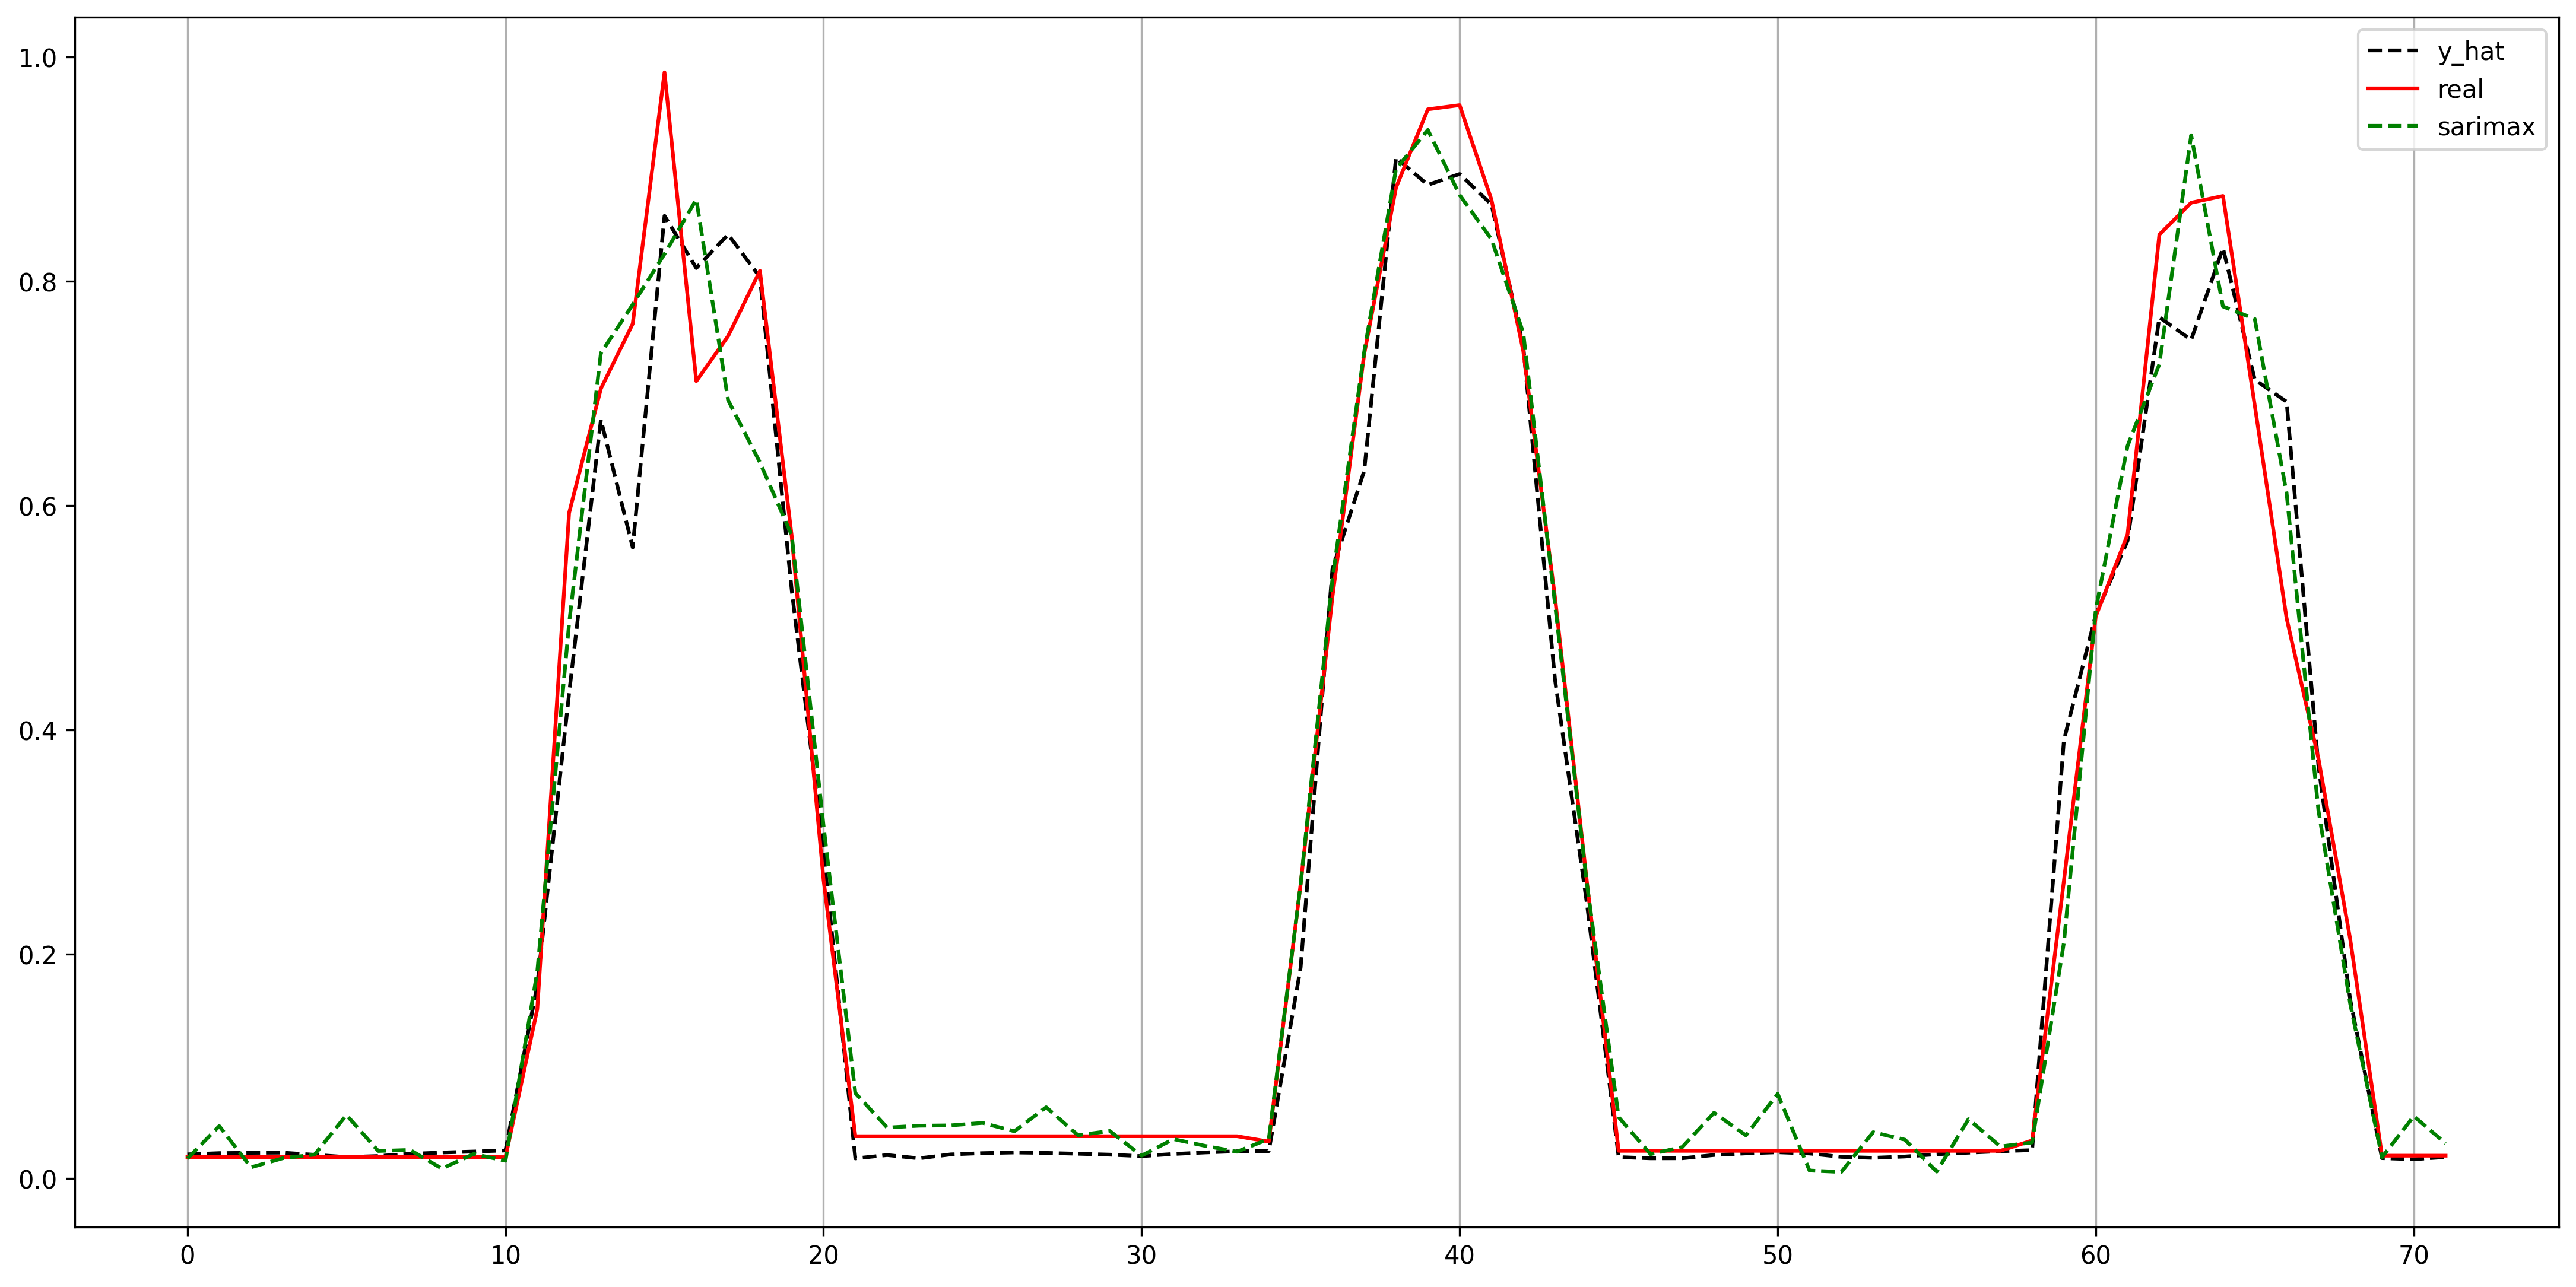

In [7]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best_mlp_residual = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best_mlp_residual[0],
                                                                                            tr_ts_percents)
erro_estimado = np.concatenate((best_mlp_residual[4].predict(erro_train_entrada),
                                best_mlp_residual[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best_mlp_residual[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best_mlp_residual[2],
                                                                best_mlp_residual[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best_mlp_residual[5].predict(X_in_train), best_mlp_residual[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best_mlp_residual[5].predict(X_in_test)

len_dt = len(data_test)

print(best_mlp_residual)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test,
                                                                        data_test),best_mlp_residual[6]))
print (mae(y_estimado_so_test, data_test) ==  best_mlp_residual[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

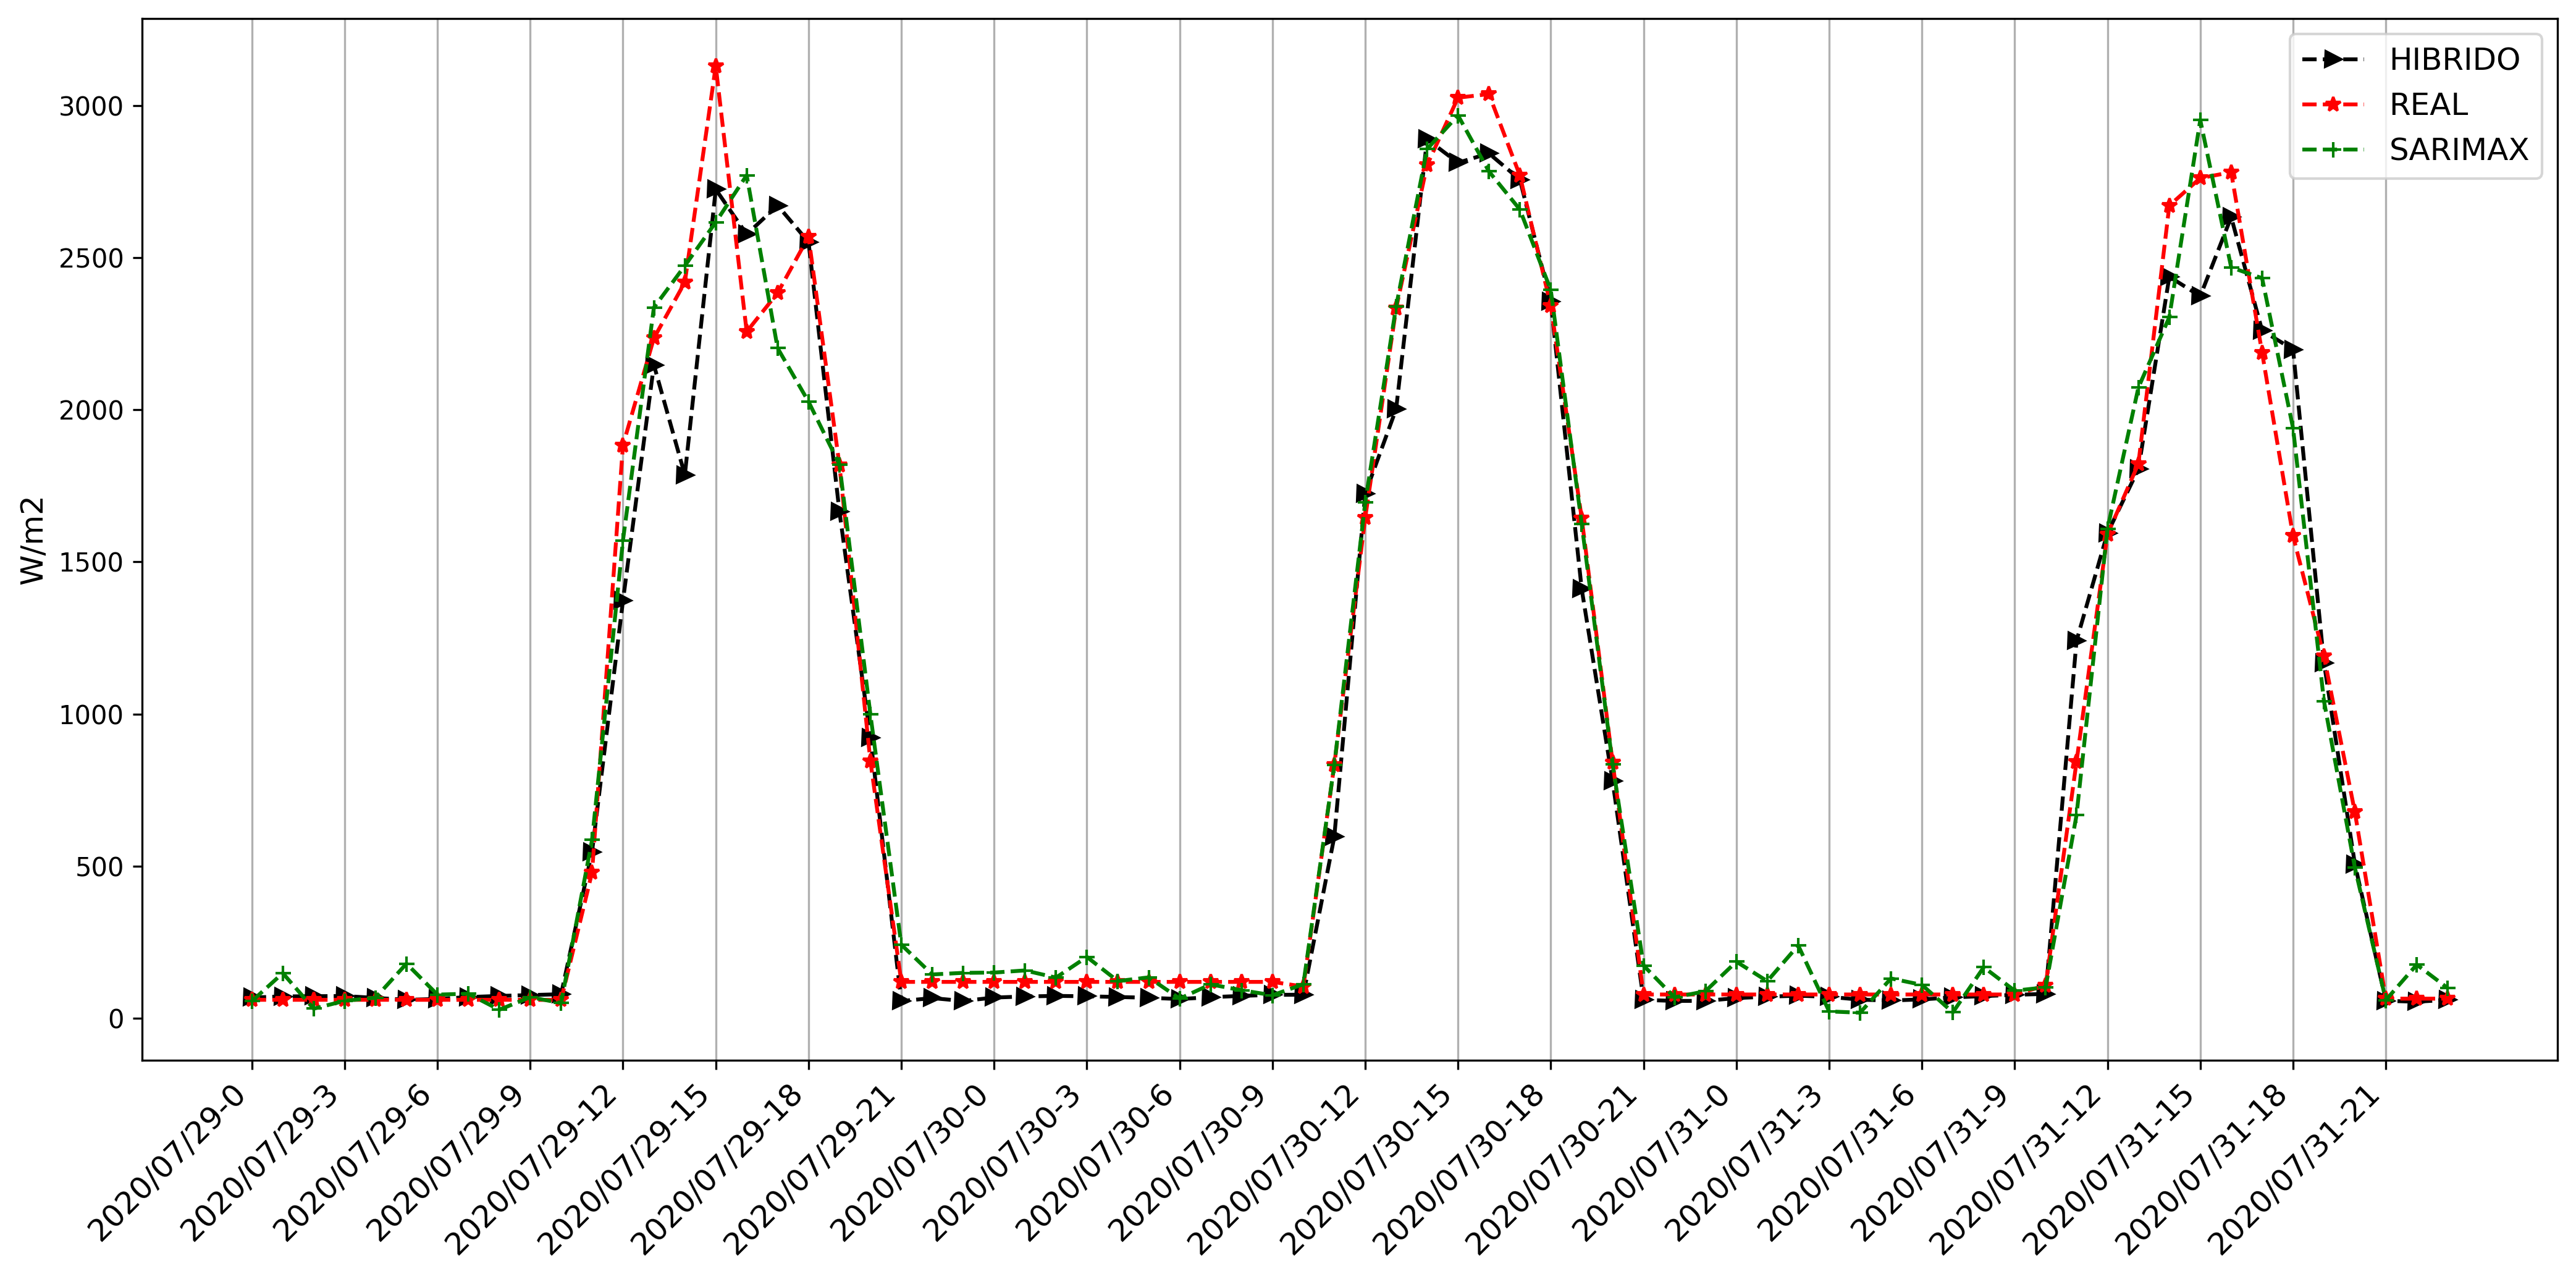

In [10]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch4_pop15.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

## Train

In [ ]:
tr_ts_percents=[80,20]

In [25]:
# ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15,
#                                        prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

# best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

# pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

100%|██████████| 4/4 [00:21<00:00,  5.34s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

100%|██████████| 4/4 [00:32<00:00,  8.11s/it]

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

100%|██████████| 4/4 [00:15<00:00,  3.94s/it]

100%|██████████| 4/4 [00:19<00:00,  4.98s/it]

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

100%|██████████| 4/4 [00:26<00:00,  6.57s/it]

100%|██████████| 4/4 [00:14<00:00,  3.57s/it]

 25%|██▌       | 1/4 [13:21<40:05, 801.89s/it]generation: 1
start_set_fit: 1

100%|██████████| 4/4 [00:18<00:00,  4.56s/it]

100%|██████████| 4/4 [00:33<00:00,  8.25s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

100%|██████████| 4/4 [00:30<00:00,  7.55s/it]

100%|██████████| 4/4 [00:17<00:00,  4.47s/it]

100%|██████████| 4/4 [00:28<00:00,  7.07s/it]

100%|██████████| 4/4 [00:31<00:00,  7.85s/it]

100%|██████████| 4/4 [00:24<00:00,  6.14s/it]

100%|███

## Análise Resultados

[3, 20, 5, 17, 11, <mlopt.AgMlp.AgMlp object at 0x0000025E400A8130>, <mlopt.AgMlp.AgMlp object at 0x0000025E4019BFA0>, 0.032241696989517794]
Teste para saber se pegou o melhor mesmo! 0.032241696989517794 == <mlopt.AgMlp.AgMlp object at 0x0000025E4019BFA0> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.032241696989517794
MSE:  0.002782641205485636
MAPE:  0.25194836125405984
GANHO MAE:
-0.03498392516502924
GANHO MSE:
-0.10075869151261152
GANHO MAPE:
0.27722477005462764


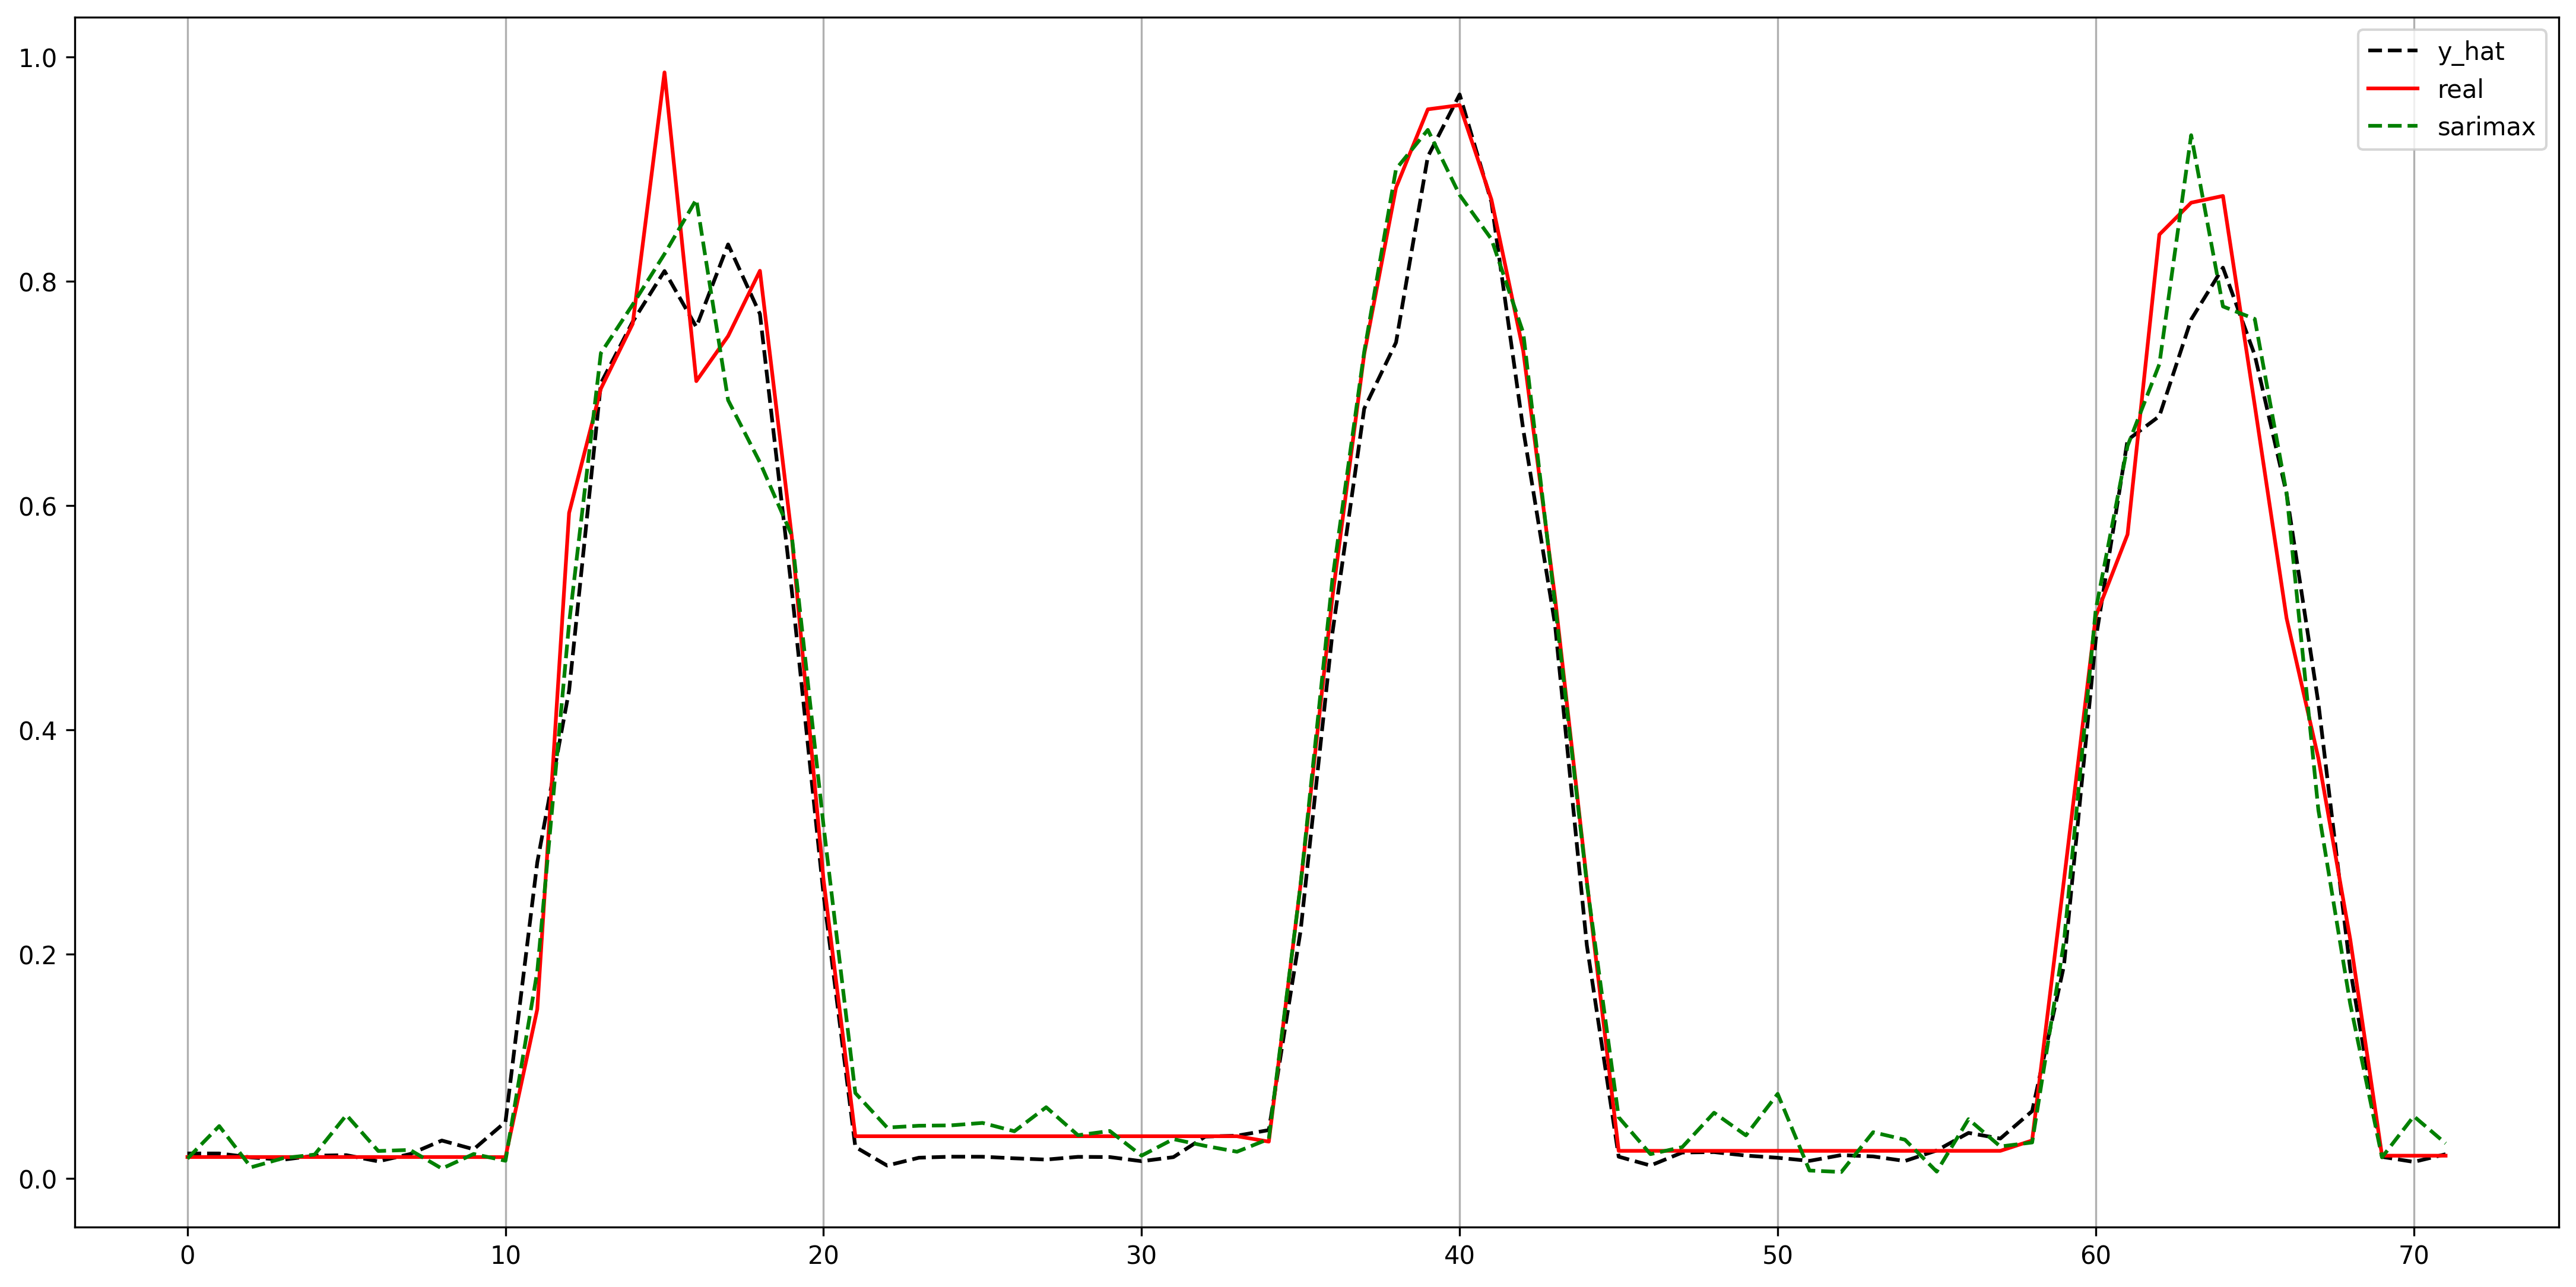

In [12]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dt:], 'k--', label='y_hat')
plt.plot(gen[-len_dt:], 'r', label='real')
plt.plot(y_sarimax[-len_dt:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

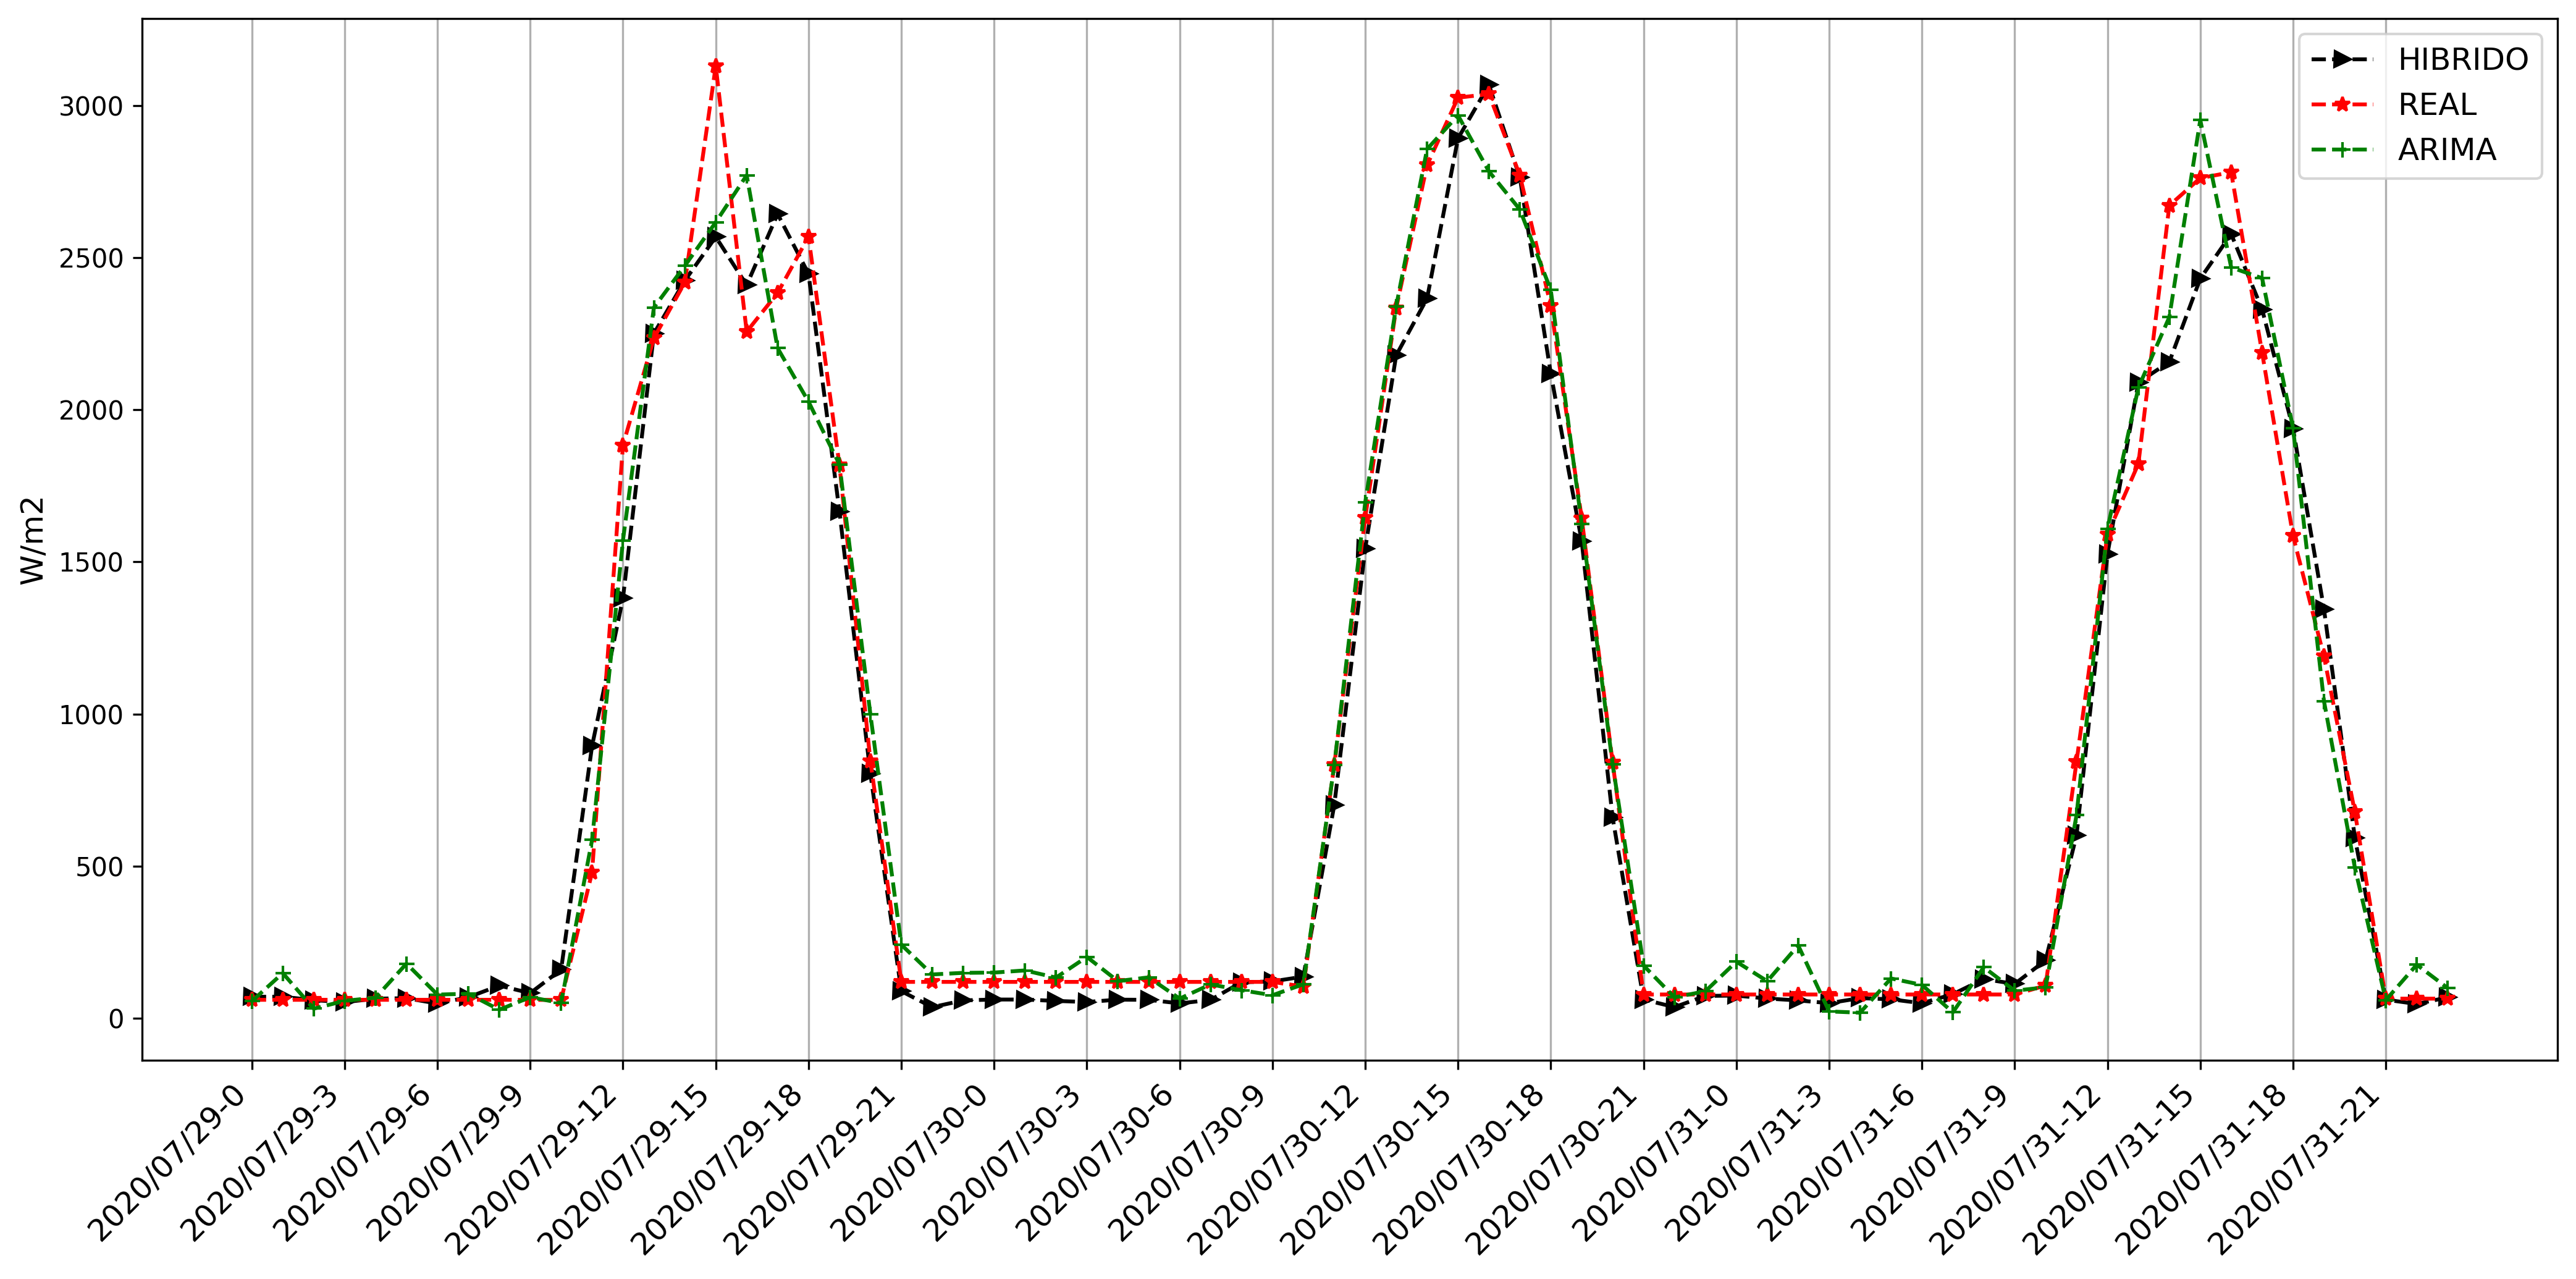

In [13]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-len_dt:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/florianopolis_agmlpvrresidual_epoch4_pop15.png', dpi=300)

# Figura Unica AG-MLP/AG-MLP-VR

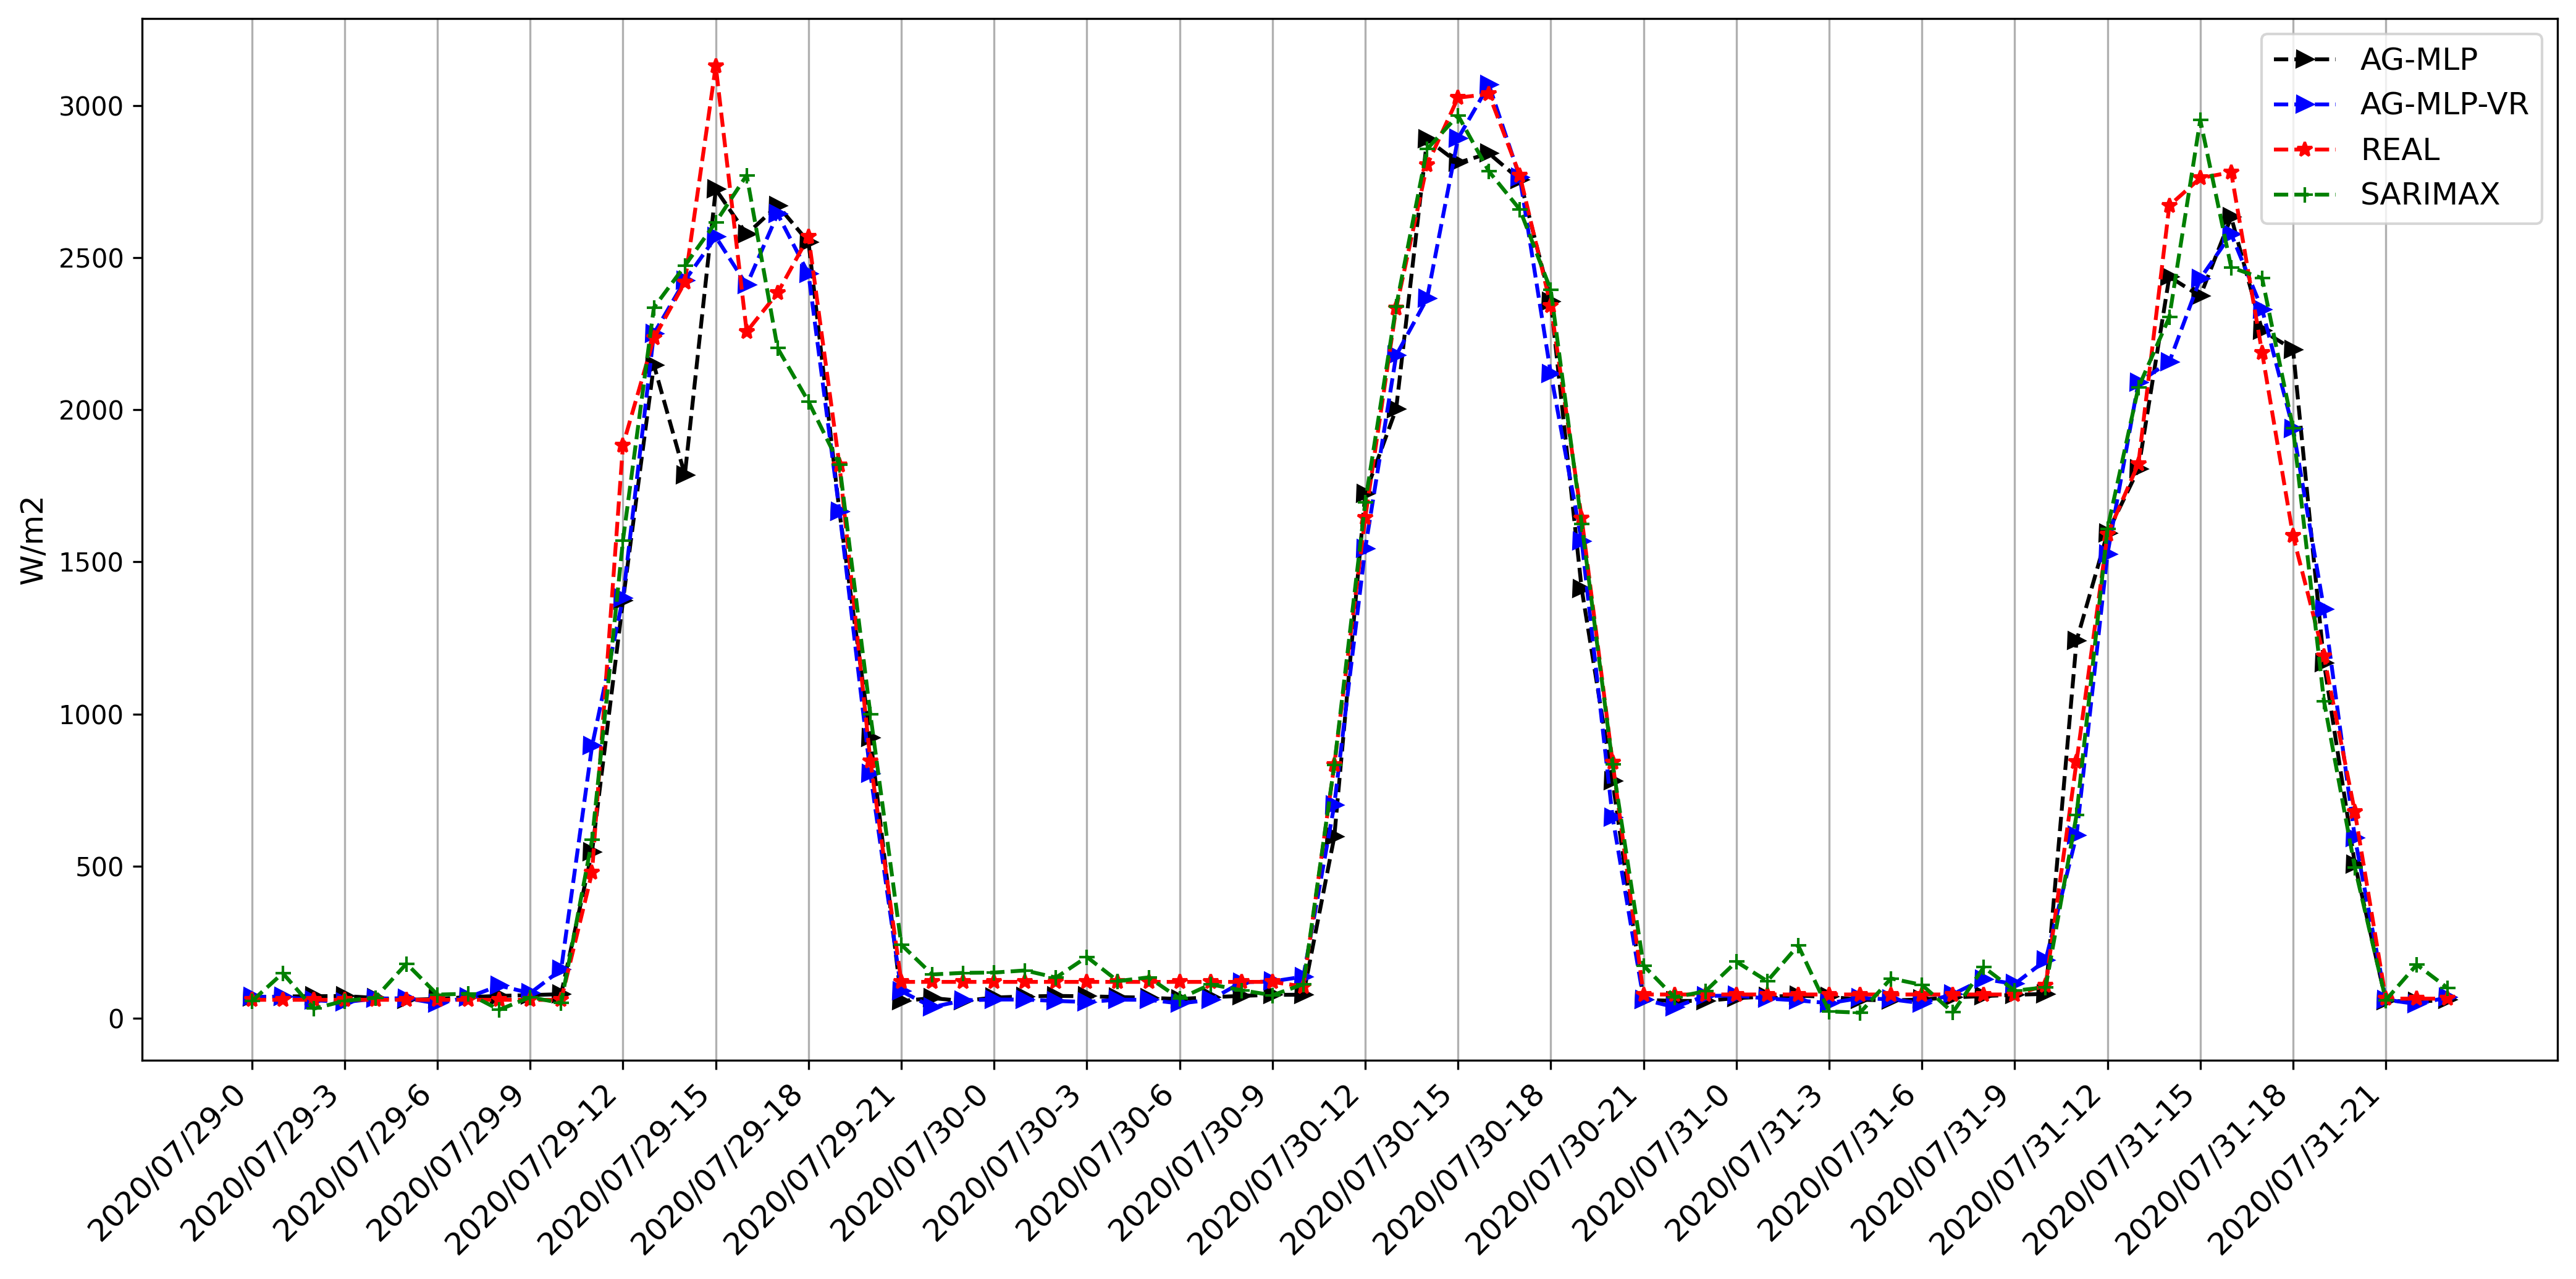

In [15]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-len_dt:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-len_dt:].reshape(-1, 1)), 'k-->', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-len_dt:].reshape(-1, 1)), 'b-->', label='AG-MLP-VR')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-len_dt:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-len_dt:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X[::3], rotation=45, ha='right', fontsize=12)
ax.grid(axis='x')
    
ax.legend(fontsize=12)
ax.set_ylabel('W/m2', fontsize=12)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids.png', dpi=300)

# Algoritmo AGEmsemble_Residual


## Train

[15, 10, 20, 1, VotingRegressor(estimators=[('SVR',
                             SVR(C=100, epsilon=0.1742386833465867,
                                 gamma='auto')),
                            ('BAG',
                             BaggingRegressor(max_samples=3, n_estimators=2)),
                            ('SGD', SGDRegressor()),
                            ('RFR',
                             RandomForestRegressor(max_depth=19,
                                                   min_samples_leaf=6,
                                                   min_weight_fraction_leaf=0.1315589727589142,
                                                   n_estimators=1)),
                            ('ADA', AdaBoostRegressor(n_estimators=38)),
                            ('LR', LinearRegression())]), VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=4,
                        

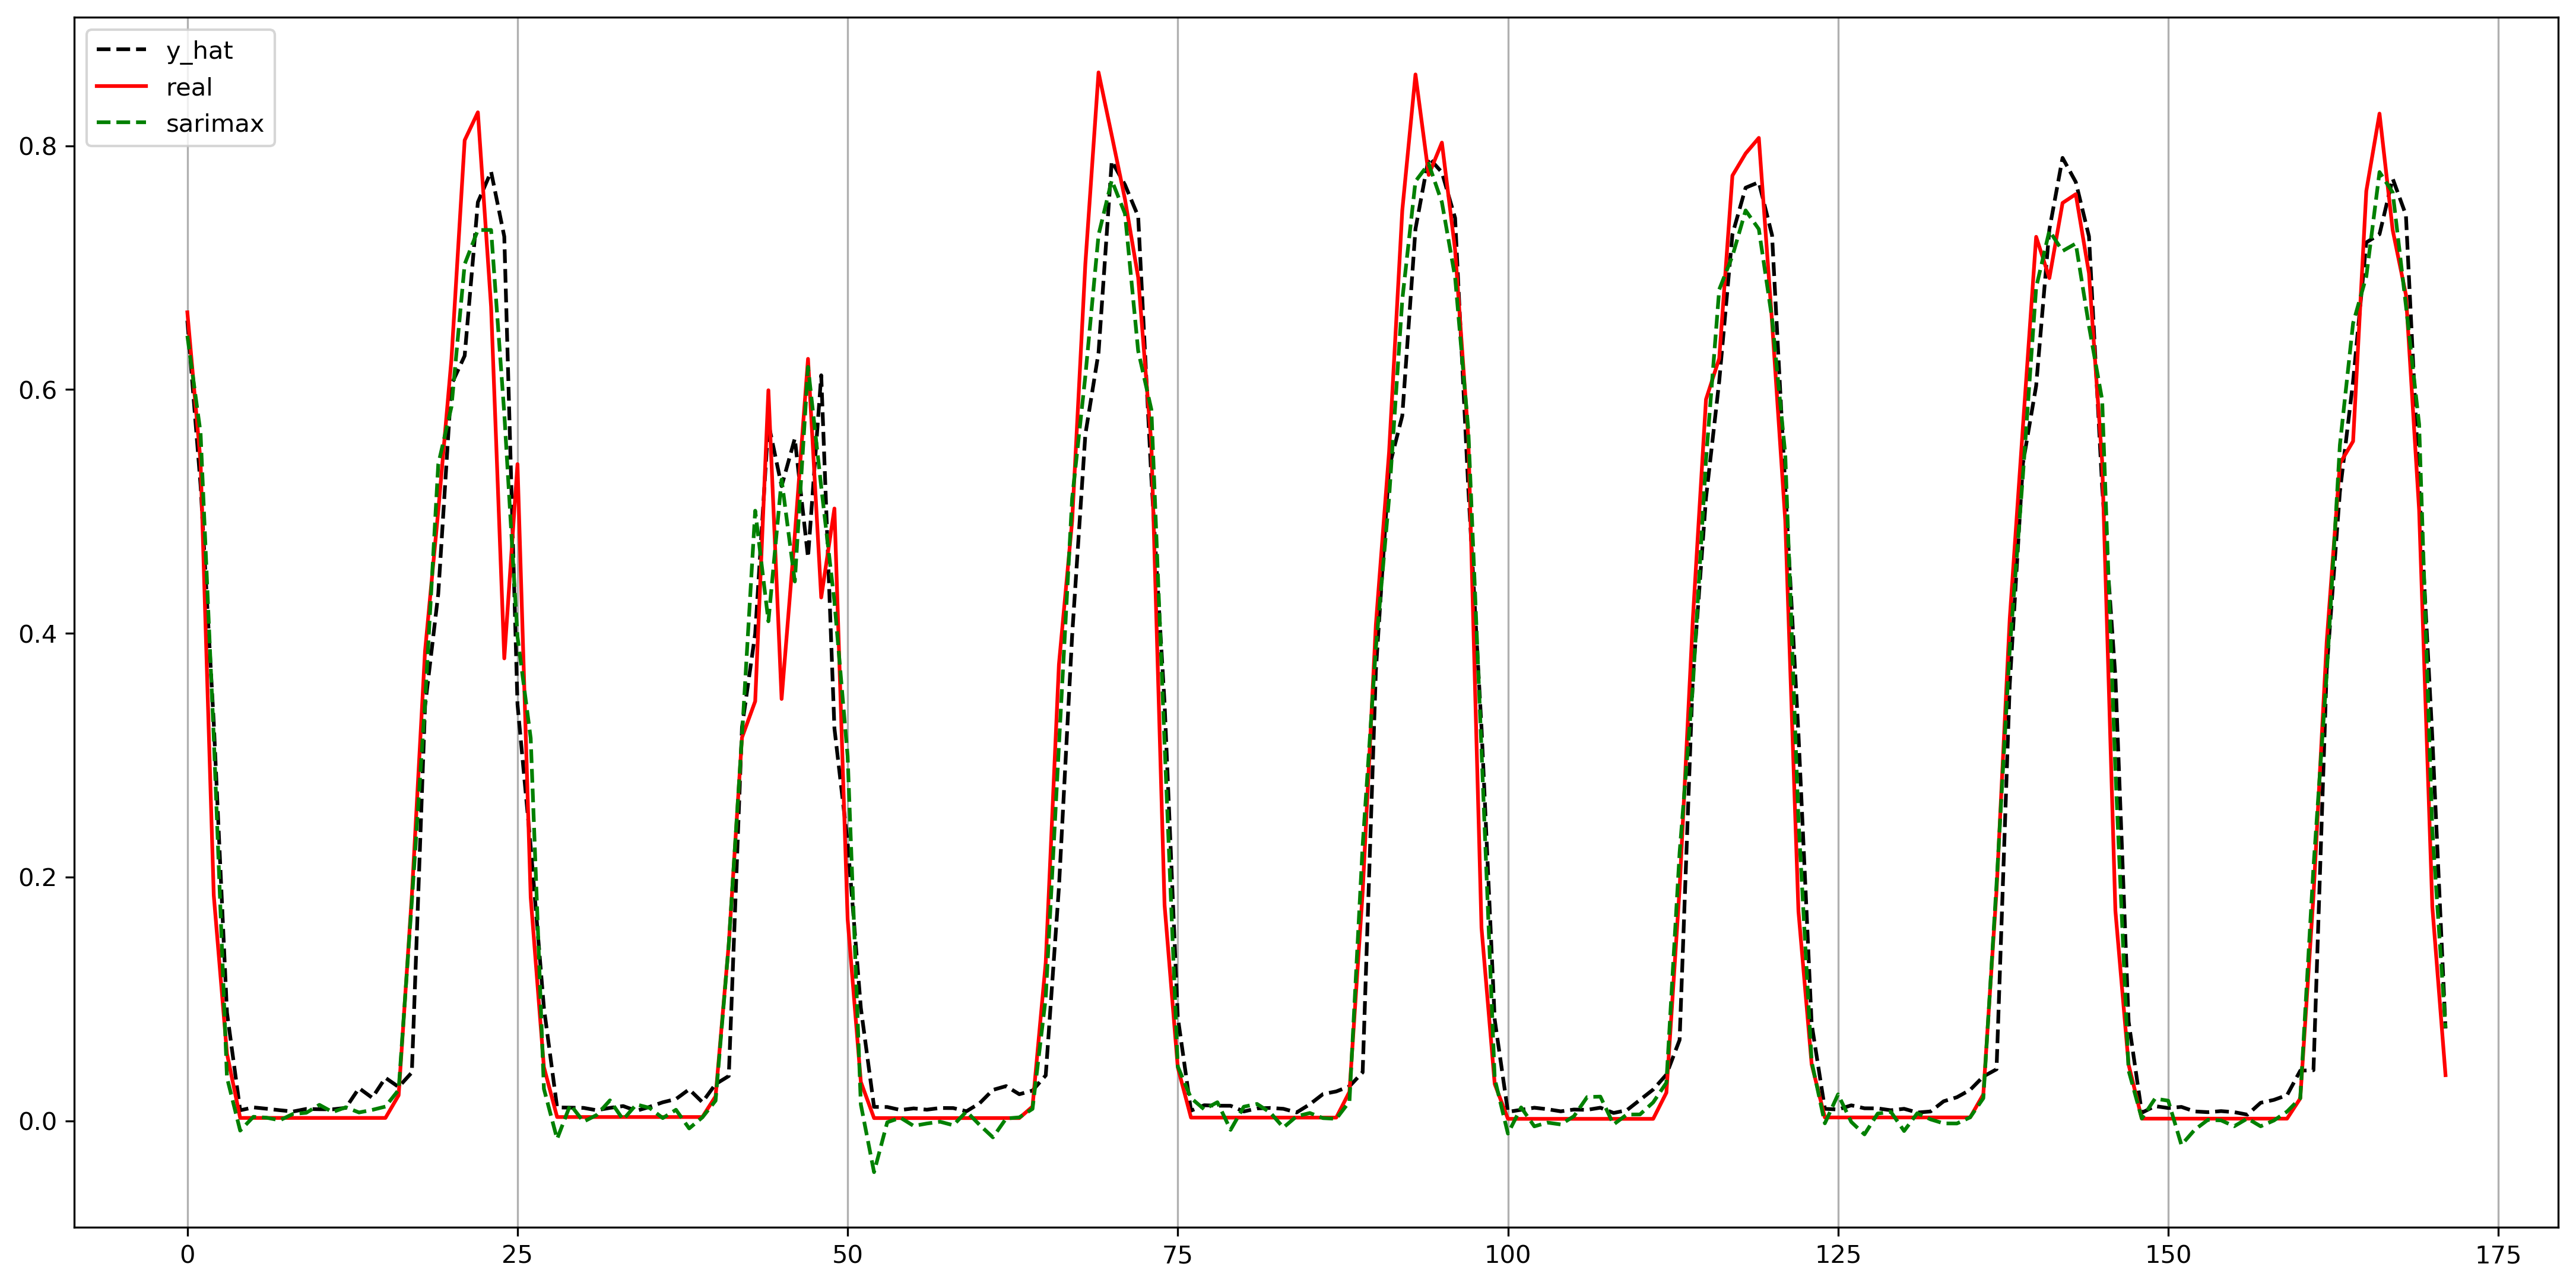

In [11]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

## Results

In [ ]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

# LSTM + MLP

Without exogenous variables

https://www.sciencedirect.com/science/article/abs/pii/S0360544218302056

https://www.sciencedirect.com/science/article/abs/pii/S0960148120308557

## Train

In [8]:
from mlopt.ACOLSTM import ACOLSTM
# Importing only here becouse TF takes too long to import

options_ACO={'antNumber':3, 'antTours':2, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = train_test_split(gen, 23,
                                                                        tr_vd_ts_percents = [80, 20],
                                                                        print_shapes = True)

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


In [12]:
lstmOptimizer = ACOLSTM(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm,1,
                        options_ACO=options_ACO)

final_model, y_hat = lstmOptimizer.optimize(searchSpace)

  0%|          | 0/2 [00:00<?, ?it/s]

2021-03-30 00:59:16,953 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:16,953: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 00:59:17,041 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 00:59:17,041: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,354 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:02:35,354: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13FAA550> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:02:35,416 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,416: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:02:35,527 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:02:35,527: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:27,865 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:05:27,865: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C14009940> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:05:27,913 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:27,913: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:05:28,237 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:05:28,237: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,108 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:12:00,108: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C8D8B0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:12:00,223 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,223: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:12:00,323 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:12:00,323: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,400 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:16:18,400: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C46C3BD30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:16:18,489 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,489: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:16:18,696 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:16:18,696: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:42,877 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:22:42,877: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:22:42,963 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:42,963: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:22:43,404 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:22:43,404: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:56,615 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:28:56,615: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49DA8D30> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:28:58,430 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,430: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:28:58,631 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:28:58,631: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,347 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:35:30,347: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C470093A0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:35:30,425 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,425: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:35:30,538 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:35:30,538: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,462 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:41:31,462: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C49FE6670> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:41:31,560 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,560: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:41:31,653 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:41:31,653: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,477 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:43:45,477: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C430> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:43:45,599 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,599: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:43:45,687 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:43:45,687: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,454 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:45:51,454: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C48C9C1F0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:45:51,549 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,549: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:45:51,652 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:45:51,652: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,514 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:47:56,514: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C4440C040> triggered tf.function retracing. Tracing is expensive and the excessive numbe

2021-03-30 01:47:56,619 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,619: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:47:56,974 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:47:56,974: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,168 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:51:32,168: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C13F0A4C0> triggered tf.function retracing. Tracing is expensive and the excessive numbe

ACO-All Best Response: [30  2 10  4 10  4  1  2]. Fitness: 0.045856797266949134



2021-03-30 01:51:32,283 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,283: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:51:32,385 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-03-30 01:51:32,385: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2021-03-30 01:57:24,542 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-03-30 01:57:24,542: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000025C445C6310> triggered tf.function retracing. Tracing is expensive and the excessive numbe

In [17]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 23, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
final_model.save('./resultados/lstm_model')

INFO:tensorflow:Assets written to: ./resultados/lstm_model\assets


2021-03-30 09:17:58,576 - tensorflow - INFO - Assets written to: ./resultados/lstm_model\assets
2021-03-30 09:17:58,576: INFO - Assets written to: ./resultados/lstm_model\assets


## Results

In [9]:
from tensorflow import keras

_, _, X_test_lstm, _ = train_test_split(gen, 23,tr_vd_ts_percents = [80, 20],print_shapes = True)

loadedmodel = keras.models.load_model('./resultados/lstm_model')
y_hat_lstm = loadedmodel.predict(X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1)))

X_train:  (288, 23)
y_train:  (288, 1)
X_test:  (72, 23)
y_test:  (72, 1)


2021-04-11 20:07:34,061 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 20:07:34,061: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 20:07:34,089 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 20:07:34,089: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 20:07:37,418 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000219874179D0> triggered tf.function retracing. Tracing is expensive and the exce

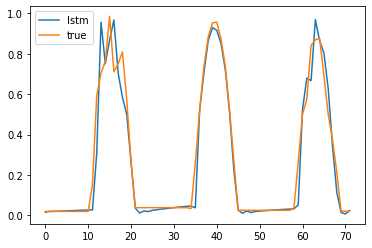

In [11]:
plt.plot(y_hat_lstm, label='lstm')
plt.plot(y_test_lstm, label='true')
plt.legend()

In [12]:
print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae(y_hat_lstm, y_test_lstm))
print('MSE: ', mse(y_hat_lstm, y_test_lstm))
print('MAPE: ', MAPE(y_hat_lstm, y_test_lstm))

Resultado Dados Teste!
LSTM
MAE:  0.04277390316496461
MSE:  0.006897473672604215
MAPE:  0.21161955504144714


# Sarimax + LSTM

## Train

In [4]:
from mlopt.LSTM_Residual import LSTM_Residual

options_ACO={'antNumber':2, 'antTours':1, 'alpha':1, 'beta':1, 'rho':0.5, 'Q':1}
fl_qtn = [10, 30, 70, 100]
fl_func = list(range(6))             
sl_qtn = [5, 10, 20, 40]
sl_func = list(range(6))
tl_qtn = [1, 10, 15]
tl_func = list(range(6))
optimizer = list(range(4))
epochs = list(range(3))
searchSpace = [fl_qtn, fl_func, sl_qtn, sl_func, tl_qtn, tl_func, optimizer, epochs]

LSTM_Residual_Obj = LSTM_Residual(gen, y_sarimax)

In [5]:
final_mode, y_hat_test_sarimax_lstm = LSTM_Residual_Obj.fit(24, searchSpace, options_ACO, saturate=False)

  0%|          | 0/1 [00:00<?, ?it/s]2021-04-11 19:30:20,452 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 19:30:20,452: WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 19:30:20,737 - tensorflow - WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 19:30:20,737: WARNING - Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
2021-04-11 19:35:23,729 - tensorflow - WARNING - Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on G

ACO-All Best Response: [100   1   5   0   1   3   2   1]. Fitness: 0.031036532048863325


2021-04-11 19:58:08,696 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000219888C9A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2021-04-11 19:58:08,696: WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000219888C9A60> triggered tf.function retracing. Tracing is expensive and the excessive numbe

shape data test arima: 
(72,)
shape error_hat_test
(72, 1)
shape y_hat_test
(72,)
Final ftiness MAE 0.031036532048863325


In [6]:
final_mode.save('./resultados/sarimax_lstm_model')

2021-04-11 19:58:16,357 - tensorflow - INFO - Assets written to: ./resultados/sarimax_lstm_model\assets
2021-04-11 19:58:16,357: INFO - Assets written to: ./resultados/sarimax_lstm_model\assets


## Results

In [13]:
_, _, _, y_test = train_test_split(gen, 24,tr_vd_ts_percents = [80, 20],print_shapes = True)

print('Resultado Dados Teste!')
print('LSTM')
print('MAE: ', mae( y_hat_test_sarimax_lstm, y_test))
print('MSE: ', mse(y_hat_test_sarimax_lstm, y_test))
print('MAPE: ', MAPE(y_hat_test_sarimax_lstm, y_test[:,0]))

X_train:  (288, 24)
y_train:  (288, 1)
X_test:  (72, 24)
y_test:  (72, 1)
Resultado Dados Teste!
LSTM
MAE:  0.031036532048863325
MSE:  0.0025287887198529304
MAPE:  0.34442579921751537


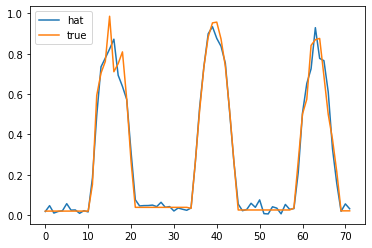

In [14]:
plt.plot(y_hat_test_sarimax_lstm, label='hat')
plt.plot(y_test, label='true')
plt.legend()